In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn.feature_map import ChebRx
from squlearn.expectation_operator import SummedPaulis
from squlearn.qnn.loss import SquaredLoss
from squlearn.qnn.qnnc import QNNClassifier
from squlearn.optimizers import SLSQP
from squlearn.util import Executor

In [2]:
executor = Executor("statevector_simulator")

Define parameterized quantum circuit $Q(x,\theta)$

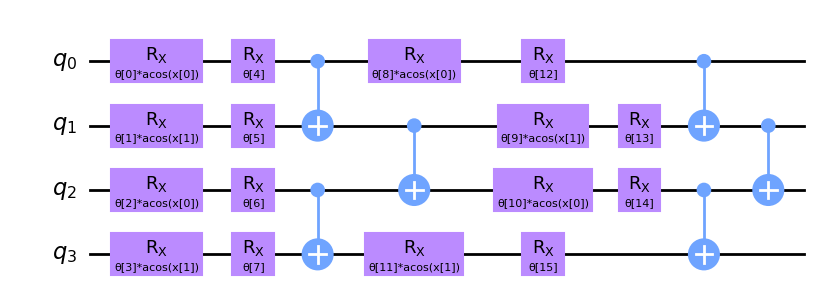

In [3]:
nqubits = 4

number_of_layers = 2
pqc = ChebRx(nqubits, 2, num_layers=number_of_layers)
pqc.draw()

Definition of the cost operator:

In [4]:
cost_op = [SummedPaulis(nqubits), SummedPaulis(nqubits)]
print(cost_op)

[SummedOp([PauliOp(Pauli('IIII'), coeff=1.0*p[0]), PauliOp(Pauli('IIIZ'), coeff=1.0*p[1]), PauliOp(Pauli('IIZI'), coeff=1.0*p[2]), PauliOp(Pauli('IZII'), coeff=1.0*p[3]), PauliOp(Pauli('ZIII'), coeff=1.0*p[4])], coeff=1.0, abelian=False), SummedOp([PauliOp(Pauli('IIII'), coeff=1.0*p[0]), PauliOp(Pauli('IIIZ'), coeff=1.0*p[1]), PauliOp(Pauli('IIZI'), coeff=1.0*p[2]), PauliOp(Pauli('IZII'), coeff=1.0*p[3]), PauliOp(Pauli('ZIII'), coeff=1.0*p[4])], coeff=1.0, abelian=False)]


In [5]:
np.random.seed(24)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.array([np.random.rand(op.num_parameters) for op in cost_op])

clf = QNNClassifier(pqc, cost_op, executor, SquaredLoss, SLSQP(), param_ini, param_op_ini)

### Generate Dataset

In [6]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = make_blobs(60, centers=2)
X = MinMaxScaler((-0.9, 0.9)).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Optimization of the classifier

In [7]:
clf.fit(X_train, y_train)

theta [0.9600173  0.69951205 0.99986729 0.2200673  0.36105635 0.73984099
 0.99645573 0.31634698 0.13654458 0.38398001 0.32051928 0.36641475
 0.70965156 0.90014243 0.53411544 0.24729376 0.67180656 0.56172911
 0.54255988 0.8934476  0.84277955 0.30601259 0.63116978 0.68023886
 0.97042756 0.89356715]
Current value: 74.28834393073751
theta [0.9600173  0.69951205 0.99986729 0.2200673  0.36105635 0.73984099
 0.99645573 0.31634698 0.13654458 0.38398001 0.32051928 0.36641475
 0.70965156 0.90014243 0.53411544 0.24729376 0.67180656 0.56172911
 0.54255988 0.8934476  0.84277955 0.30601259 0.63116978 0.68023886
 0.97042756 0.89356715]
Grad length: 175.46945149094648
grad [-82.63297976  -6.99788474 -16.15309684  30.33656311 -45.19783359
  -8.22915625 -16.82658361  12.36071926 -31.45196339 -47.97477443
 -20.04972319  30.33656311 -19.53842185 -22.88180983 -10.46116969
  12.36071926 -62.43023926 -23.48456855 -48.75862942 -30.79200507
 -43.93351179 -62.43023926  12.267332   -19.45650625  11.42281404
 -11

In [8]:
print("Result Param:", clf.param)
print("Result ParamOp:", clf.param_op)

Result Param: [ 1.3376441  -0.50194285  2.02555484 -0.50622132  1.86130457  0.18835344
  2.16462906  0.107222    0.20204243  0.71131813 -0.14404297 -0.35987387
  1.06911804  1.11821852  0.88613628  0.03816879]
Result ParamOp: [ 1.33125251 -0.18812479  1.73512192  1.05998542  2.03903742  0.96545853
  1.35262833 -0.32812948  0.58044355  0.86596933]


In [9]:
clf.score(X_test, y_test)

1.0

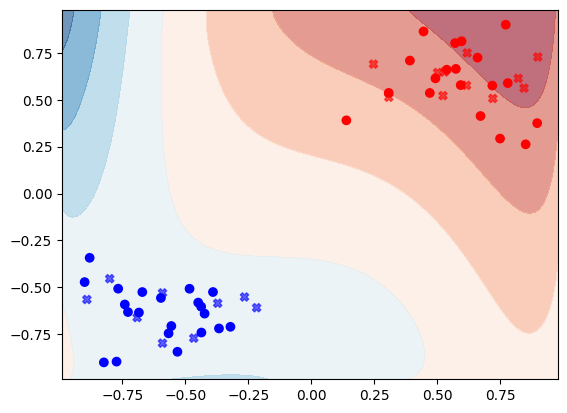

In [10]:
from matplotlib.colors import ListedColormap

xx, yy = np.meshgrid(np.arange(-0.99, 0.99, 0.01), np.arange(-0.99, 0.99, 0.01))

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

Z = clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.6)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, marker="X")